In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import momepy as mm
import networkx as nx
import cenpy as cp

print(ox.__version__)
print(mm.__version__)

1.2.1
0.5.3


In [48]:
%time G =  ox.graph.graph_from_place('Rhode Island, USA', network_type='drive')

CPU times: user 1min 15s, sys: 1.09 s, total: 1min 16s
Wall time: 1min 16s


In [49]:
%time nodes, edges = ox.graph_to_gdfs(G)

CPU times: user 6.69 s, sys: 46 ms, total: 6.74 s
Wall time: 6.76 s


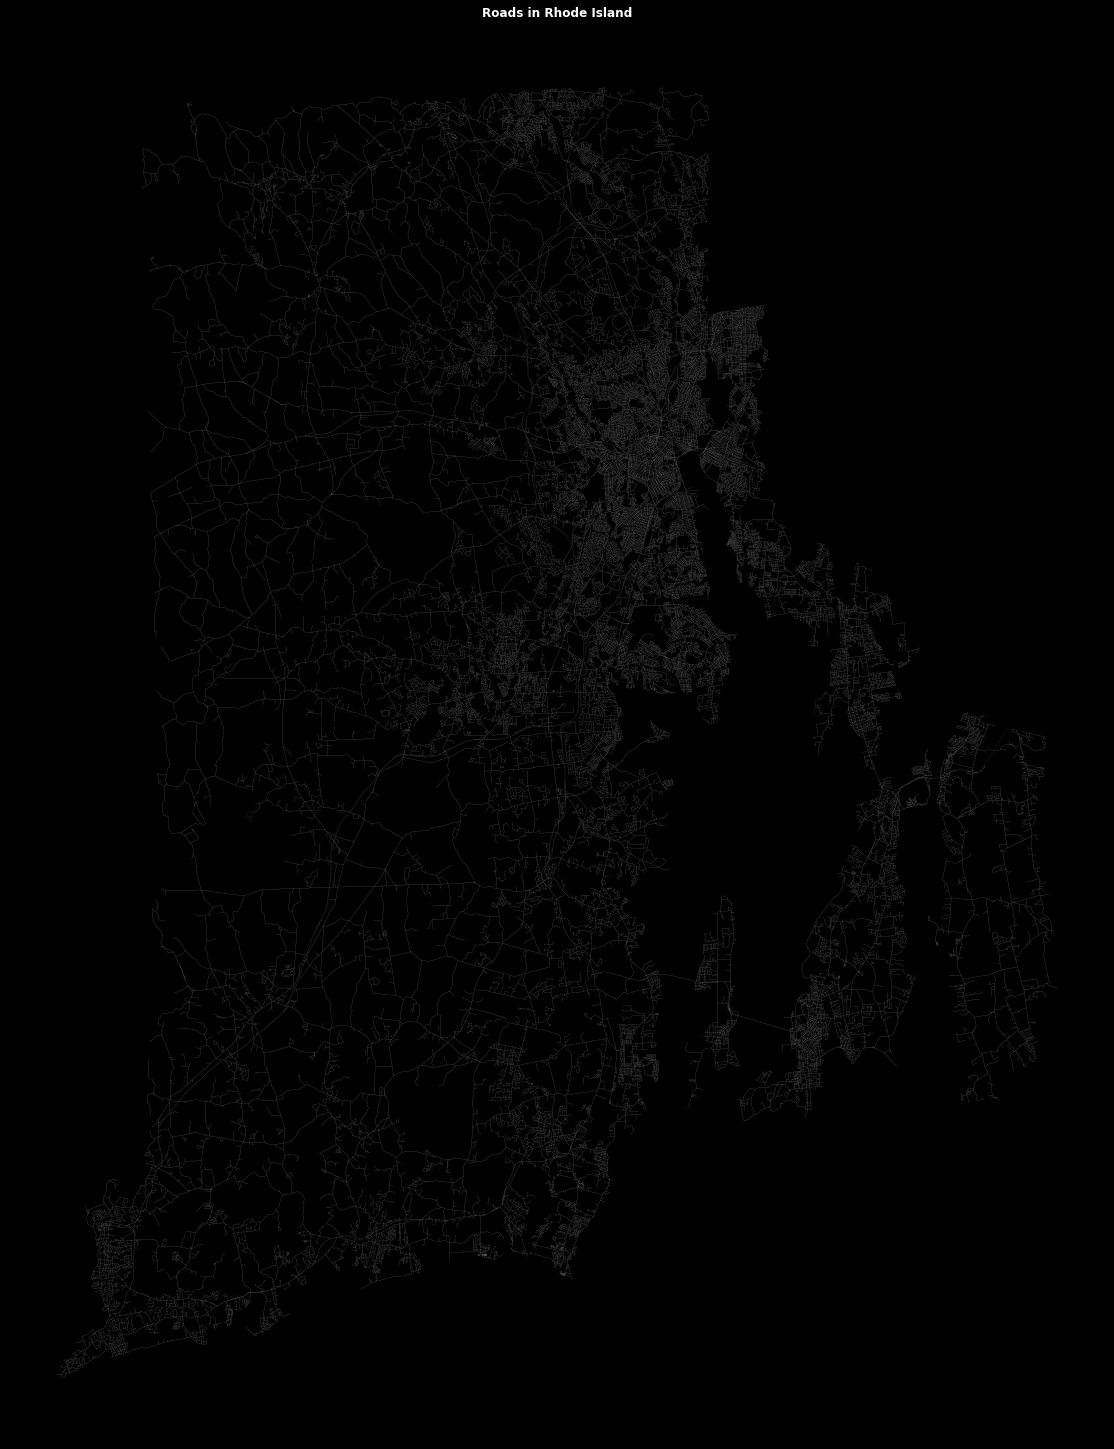

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       facecolor='k',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

edges.plot(ax=ax, color='w', alpha=0.5, lw=0.1)
    
ax.set_title("Roads in Rhode Island", color='w', weight='bold')
ax.set_axis_off()
    
fig.savefig('street-topology-rhode-island-1.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')

In [51]:
nodes.head()

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
201272668,41.339684,-71.785545,3,NaN,NaN,POINT (-71.78554 41.33968)
201272693,41.339058,-71.785408,1,NaN,NaN,POINT (-71.78541 41.33906)
201272814,41.375141,-71.823181,3,NaN,NaN,POINT (-71.82318 41.37514)
201272837,41.377701,-71.822197,4,NaN,NaN,POINT (-71.82220 41.37770)
201272856,41.380798,-71.820862,3,NaN,NaN,POINT (-71.82086 41.38080)


In [52]:
edges.head()

osmid    ref             name      highway  \
u         v         key                                                   
201272668 201656854 0    234710643  RI 1A       Shore Road    secondary   
          201272693 0     19361681    NaN          Liberty  residential   
          201610846 0    234710643  RI 1A       Shore Road    secondary   
201272693 201272668 0     19361681    NaN          Liberty  residential   
201272814 201272837 0     19361692    NaN  Highland Avenue  residential   

                         oneway reversed   length  \
u         v         key                             
201272668 201656854 0     False     True   10.547   
          201272693 0     False    False   74.933   
          201610846 0     False    False  354.562   
201272693 201272668 0     False     True   74.933   
201272814 201272837 0     False    False  296.337   

                                                                  geometry  \
u         v         key                                                      
201272668 201656854 0    LINESTRING (-71.78554 41.33968, -71.78564 41.3...   
          201272693 0    LINESTRING (-71.78554 41.33968, -71.78548 41.3...   
          201610846 0    LINESTRING (-71.78554 41.33968, -71.78537 41.3...   
201272693 201272668 0    LINESTRING (-71.78541 41.33906, -71.78539 41.3...   
201272814 201272837 0    LINESTRING (-71.82318 41.37514, -71.82314 41.3...   

                        lanes access junction maxspeed bridge width tunnel  
u         v         key                                                     
201272668 201656854 0     NaN    NaN      NaN      NaN    NaN   NaN    NaN  
          201272693 0     NaN    NaN      NaN      NaN    NaN   NaN    NaN  
          201610846 0     NaN    NaN      NaN      NaN    NaN   NaN    NaN  
201272693 201272668 0     NaN    NaN      NaN      NaN    NaN   NaN    NaN  
201272814 201272837 0     NaN    NaN      NaN      NaN    NaN   NaN    NaN

In [53]:
state = 44
year = 2019

url = f"https://www2.census.gov/geo/tiger/GENZ{year}/shp/cb_{year}_{state}_bg_500k.zip"

<AxesSubplot:>

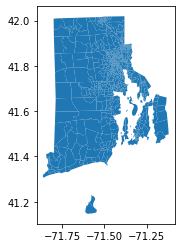

In [54]:
state = gpd.read_file(url)
state.geometry.plot()

In [55]:
state = state.to_crs(nodes.crs)

In [56]:
from scipy import stats
num_bins = 36
min_bins = 4

threshold = 10

max_entropy = np.log(num_bins)

perfect_grid = [1] * min_bins + [0] * (num_bins - min_bins)
perfect_grid_entropy = stats.entropy(perfect_grid)

In [57]:
def reverse_bearing(x):
    return x + 180 if x < 180 else x - 180

def get_unweighted_bearings(G, threshold):
    # calculate edge bearings
    # threshold lets you discard streets < some length from the bearings analysis
    b = pd.Series([d['bearing'] for u, v, k, d in G.edges(keys=True, data=True) if d['length'] > threshold])
    return pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')

def count_and_merge(n, bearings):
    # make twice as many bins as desired, then merge them in pairs
    # prevents bin-edge effects around common values like 0° and 90°
    n = n * 2
    bins = np.arange(n + 1) * 360 / n
    count, _ = np.histogram(bearings, bins=bins)
    
    # move the last bin to the front, so eg 0.01° and 359.99° will be binned together
    count = np.roll(count, 1)
    return count[::2] + count[1::2]

def calculate_orientation_entropy(data, n):
    bin_counts = count_and_merge(n, data)
    entropy = stats.entropy(bin_counts)
    return entropy

def orientation_order(eta, max_ent=max_entropy, min_ent=perfect_grid_entropy):
    # normalize it as a value between perfect_grid_entropy and max_entropy
    # then square it to approx linearize orientation_order's relationship with the
    # share of total bins with equal non-zero probabilities
    return 1 - ((eta - min_ent) / (max_ent - min_ent)) ** 2

In [ ]:
%%time

misses = np.empty(0)
errors = np.empty(0)

results = {}

for i in state.index:
    
    geoid = state['GEOID'][i]
    print(geoid)
    
    poly = state.geometry[i].buffer(0.0001)
    
    try: 
        intersecting_nodes = nodes[nodes.intersects(poly)].index
        G_sub = G.subgraph(intersecting_nodes) 
    except: 
        misses = np.append(misses, geoid)
        pass
    
    n, e = ox.graph_to_gdfs(ox.add_edge_bearings(G))
    n_stats = n.agg({'street_count': ['count', 'mean']})
    e_stats = e.agg({'length': ['sum', 'count', 'mean']})
    
    bearings = e[e['length'] > threshold]['bearing']
    orientation_entropy = calculate_orientation_entropy(bearings.dropna(), num_bins)
    
    net_stats = ox.stats.basic_stats(G)
    
    order = orientation_order(orientation_entropy)
    
    try: 
        inter = net_stats['streets_per_node_proportions'][4]
    except:
        inter = 0
        errors = np.append(errors, geoid)
        
    lined = 1 / net_stats['circuity_avg']
    
    results[geoid] = {'node_count': n_stats.iloc[0, 0],
                      'typical_intersection': n_stats.iloc[1, 0],
                      'edge_length': e_stats.iloc[2, 0],
                      'edge_count': e_stats.iloc[1, 0],
                      'edge_total': e_stats.iloc[0, 0],
                      'orientation_order': order,
                      'prop_4way': inter,
                      'straightness': lined,
                      'grid_index': stats.gmean([order, inter, lined])}

results = pd.DataFrame(results).T

440070169001
440070115002
